In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import re
from collections import Counter
from sklearn.model_selection import train_test_split

In [2]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.hidden_size = hidden_size

        self.W1 = nn.Linear(hidden_size, hidden_size)
        self.W2 = nn.Linear(hidden_size, hidden_size)

        self.V = nn.Linear(hidden_size,1)

    def forward(self, encoder_outputs, decoder_hidden):
        #encoder output should be like (batchsize x seq_len x hidden_size)
        # decoder hidden should be like (batch_size x hidden_size)

        seq_len = encoder_outputs.size(1)
        decoder_hidden = decoder_hidden.unsqueeze(1).repeat(1,seq_len,1)

        score = self.V(torch.tanh(self.W1(decoder_hidden)+self.W2(encoder_outputs)))

        attention_weights = F.softmax(score, dim=1).squeeze(2)

        context_vector = torch.bmm(attention_weights.unsqueeze(1), encoder_outputs)
        context_vector = context_vector.squeeze(1)

        return context_vector, attention_weights

In [3]:
class LuongDotAttention(nn.Module):
    def __init__(self):
        super(LuongDotAttention, self).__init__()

    def forward(self, encoder_outputs, decoder_hidden):
        seq_len = encoder_outputs.size(1)
        decoder_hidden = decoder_hidden.unsqueeze(2)

        score = torch.bmm(encoder_outputs, decoder_hidden)
        attention_weights = F.softmax(score.squeeze(2), dim =1)
        context_vector = torch.bmm(attention_weights.unsqueeze(1), encoder_outputs).squeeze(1)

        return context_vector, attention_weights


In [4]:
class LuongGeneralAttention(nn.Module):
    def __init__(self, hidden_size):
        super(LuongGeneralAttention, self).__init__()
        self.W = nn.Linear(hidden_size, hidden_size, bias=False)

    def forward(self, encoder_outputs, decoder_hidden):
        transformed = self.W(encoder_outputs)
        decoder_hidden = decoder_hidden.unsqueeze(2)
        score = torch.bmm(transformed, decoder_hidden)
        attention_weights = torch.softmax(score.squeeze(2), dim=1)
        context_vector = torch.bmm(attention_weights.unsqueeze(1), encoder_outputs).squeeze(1)
        return context_vector, attention_weights

In [5]:
class LuongConcatAttention(nn.Module):
    def __init__(self, hidden_size):
        super(LuongConcatAttention, self).__init__()
        self.W = nn.Linear(hidden_size * 2, hidden_size)
        self.v = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, encoder_outputs, decoder_hidden):
        seq_len = encoder_outputs.size(1)
        decoder_hidden = decoder_hidden.unsqueeze(1).repeat(1, seq_len, 1)
        concat = torch.cat((encoder_outputs, decoder_hidden), dim=2)
        score = self.v(torch.tanh(self.W(concat)))
        attention_weights = torch.softmax(score.squeeze(2), dim=1)
        context_vector = torch.bmm(attention_weights.unsqueeze(1), encoder_outputs).squeeze(1)
        return context_vector, attention_weights


In [6]:
import pandas as pd

splits = {'train': 'plain_text/train-00000-of-00001.parquet', 'test': 'plain_text/test-00000-of-00001.parquet', 'unsupervised': 'plain_text/unsupervised-00000-of-00001.parquet'}
df = pd.read_parquet("hf://datasets/stanfordnlp/imdb/" + splits["train"])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [7]:
df.head()

,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0


In [8]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', "", text)
    tokens = text.split()
    return tokens

df['tokens'] = df['text'].apply(preprocess_text)

all_tokens = [token for tokens in df['tokens'] for token in tokens]
vocal_counter = Counter(all_tokens)
vocab = ['<PAD>', '<UNK>'] + [word for word, freq in vocal_counter.items() if freq>=2]
word2idx = {word: idx for idx, word in enumerate(vocab)}

def encode_tokens(tokens, word2idx, max_len = 500):
    idxs = [word2idx.get(token, word2idx['<UNK>']) for token in tokens]
    if len(idxs) < max_len :
        idxs += [word2idx['<PAD>']]*(max_len-len(idxs))
    else:
        idxs = idxs[:max_len]

    return idxs

df['input_ids'] = df['tokens'].apply(lambda tokens: encode_tokens(tokens, word2idx))

In [9]:
df.head()

,text,label,tokens,input_ids
0,I rented I AM CURIOUS-YELLOW from my video sto...,0,"[i, rented, i, am, curiousyellow, from, my, vi...","[2, 3, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
1,"""I Am Curious: Yellow"" is a risible and preten...",0,"[i, am, curious, yellow, is, a, risible, and, ...","[2, 4, 180, 181, 52, 40, 182, 89, 183, 184, 18..."
2,If only to avoid making this type of film in t...,0,"[if, only, to, avoid, making, this, type, of, ...","[31, 206, 34, 292, 73, 36, 293, 11, 155, 22, 1..."
3,This film was probably inspired by Godard's Ma...,0,"[this, film, was, probably, inspired, by, goda...","[36, 155, 19, 334, 335, 28, 336, 1, 1, 89, 2, ..."
4,"Oh, brother...after hearing about this ridicul...",0,"[oh, brotherafter, hearing, about, this, ridic...","[380, 1, 381, 67, 36, 382, 155, 48, 383, 112, ..."


In [10]:
train_df, val_df = train_test_split(df, test_size=0.1, random_state=42, stratify=df['label'])

def df_to_tensors(dataframe):
    X = torch.tensor(dataframe['input_ids'].tolist(), dtype=torch.long)
    y = torch.tensor(dataframe['label'].tolist(), dtype=torch.long)
    return X, y

X_train, y_train = df_to_tensors(train_df)
X_val, y_val = df_to_tensors(val_df)

print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}")
print(f"Vocab size: {len(vocab)}")

Train shape: torch.Size([22500, 500]), Validation shape: torch.Size([2500, 500])
Vocab size: 57469


In [11]:
glove_path = 'glove.6B.100d.txt'
embedding_dim = 100

def load_glove_embeddings(glove_path):
    embedding_index = {}
    with open(glove_path, encoding='utf8') as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embedding_index[word] = vector
    return embedding_index

glove_embeddings = load_glove_embeddings(glove_path)

In [12]:
#creating embedding matrix
embedding_matrix = np.zeros((len(vocab), embedding_dim))
for i, word in enumerate(vocab):
    vector = glove_embeddings.get(word)
    if vector is not None:
        embedding_matrix[i] = vector
    else:
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim,))

embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)

print(f"Embedding matrix shape: {embedding_matrix.shape}")

Embedding matrix shape: torch.Size([57469, 100])


In [13]:
class SentimentRNN(nn.Module):
    def __init__(self, embedding_matrix, rnn_type, hidden_size=128, num_layers = 1, bidirectional = False, attention = None, num_classes = 2, dropout=0.2):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        self.rnn_type = rnn_type
        self.bidirectional = bidirectional
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.attention = attention

        if rnn_type == 'RNN':
            self.rnn = nn.RNN(embedding_matrix.shape[1], hidden_size, num_layers, batch_first=True, bidirectional=bidirectional, dropout=dropout)
        elif rnn_type == 'LSTM':
            self.rnn = nn.LSTM(embedding_matrix.shape[1], hidden_size, num_layers, batch_first=True, bidirectional=bidirectional, dropout=dropout)
        else:
            raise ValueError("rnn_type must be 'RNN' or 'LSTM'")

        self.fc = nn.Linear(hidden_size * (2 if bidirectional else 1), num_classes)

    def forward(self, x):
        emb = self.embedding(x)
        if self.rnn_type == 'LSTM':
            outputs, (h_n, _) = self.rnn(emb)
        else:
            outputs, h_n = self.rnn(emb)

        if self.attention is not None:
            # Use last hidden state for attention query
            if self.bidirectional:
                h_last = torch.cat([h_n[-2], h_n[-1]], dim=1)
            else:
                h_last = h_n[-1]
            context, attn_weights = self.attention(outputs, h_last)
            out = self.fc(context)
            return out, attn_weights
        else:
            # Use last hidden state
            if self.bidirectional:
                h_last = torch.cat([h_n[-2], h_n[-1]], dim=1)
            else:
                h_last = h_n[-1]
            out = self.fc(h_last)
            return out, None

In [14]:
hidden_size = 128
num_layers = 1
num_classes = 2

model_rnn = SentimentRNN(embedding_matrix, rnn_type='RNN', hidden_size=hidden_size, num_layers=num_layers, bidirectional=False, attention=None, num_classes=num_classes)
model_lstm = SentimentRNN(embedding_matrix, rnn_type='LSTM', hidden_size=hidden_size, num_layers=num_layers, bidirectional=False, attention=None, num_classes=num_classes)
model_birnn = SentimentRNN(embedding_matrix, rnn_type='RNN', hidden_size=hidden_size, num_layers=num_layers, bidirectional=True, attention=None, num_classes=num_classes)
model_bilstm = SentimentRNN(embedding_matrix, rnn_type='LSTM', hidden_size=hidden_size, num_layers=num_layers, bidirectional=True, attention=None, num_classes=num_classes)

model_rnn_attn = SentimentRNN(embedding_matrix, rnn_type='RNN', hidden_size=hidden_size, num_layers=num_layers, bidirectional=False, attention=BahdanauAttention(hidden_size), num_classes=num_classes)
model_lstm_attn = SentimentRNN(embedding_matrix, rnn_type='LSTM', hidden_size=hidden_size, num_layers=num_layers, bidirectional=False, attention=BahdanauAttention(hidden_size), num_classes=num_classes)
model_birnn_attn = SentimentRNN(embedding_matrix, rnn_type='RNN', hidden_size=hidden_size, num_layers=num_layers, bidirectional=True, attention=BahdanauAttention(hidden_size*2), num_classes=num_classes)
model_bilstm_attn = SentimentRNN(embedding_matrix, rnn_type='LSTM', hidden_size=hidden_size, num_layers=num_layers, bidirectional=True, attention=BahdanauAttention(hidden_size*2), num_classes=num_classes)

model = model_bilstm_attn

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


In [15]:
from torch.utils.data import TensorDataset, DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

batch_size = 64
epochs = 5
lr = 1e-3

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct_train = 0
        total_train = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs, _ = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * X_batch.size(0)
            preds = torch.argmax(outputs, dim=1)
            correct_train += (preds == y_batch).sum().item()
            total_train += y_batch.size(0)
        avg_loss = total_loss / len(train_loader.dataset)
        train_acc = correct_train / total_train
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_loss:.4f} - Train Accuracy: {train_acc:.4f}", end='; ')

        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs, _ = model(X_batch)
                preds = torch.argmax(outputs, dim=1)
                correct += (preds == y_batch).sum().item()
                total += y_batch.size(0)
        val_acc = correct / total
        print(f"Validation Accuracy: {val_acc:.4f}")

# To train
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=epochs)

Epoch 1/5 - Train Loss: 0.4427 - Train Accuracy: 0.7825; Validation Accuracy: 0.8696
Epoch 2/5 - Train Loss: 0.2436 - Train Accuracy: 0.9027; Validation Accuracy: 0.8888
Epoch 3/5 - Train Loss: 0.1457 - Train Accuracy: 0.9459; Validation Accuracy: 0.8924
Epoch 4/5 - Train Loss: 0.0687 - Train Accuracy: 0.9768; Validation Accuracy: 0.8876
Epoch 5/5 - Train Loss: 0.0242 - Train Accuracy: 0.9933; Validation Accuracy: 0.8852



Model: RNN


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 1/5 - Validation Accuracy: 0.4996
Epoch 2/5 - Validation Accuracy: 0.4984
Epoch 3/5 - Validation Accuracy: 0.5100
Epoch 4/5 - Validation Accuracy: 0.5064
Epoch 5/5 - Validation Accuracy: 0.5048

Model: LSTM
Epoch 1/5 - Validation Accuracy: 0.5004
Epoch 2/5 - Validation Accuracy: 0.5156
Epoch 3/5 - Validation Accuracy: 0.5192
Epoch 4/5 - Validation Accuracy: 0.5212
Epoch 5/5 - Validation Accuracy: 0.5152

Model: BiRNN
Epoch 1/5 - Validation Accuracy: 0.5500
Epoch 2/5 - Validation Accuracy: 0.5448
Epoch 3/5 - Validation Accuracy: 0.5540
Epoch 4/5 - Validation Accuracy: 0.5512
Epoch 5/5 - Validation Accuracy: 0.5484

Model: BiLSTM
Epoch 1/5 - Validation Accuracy: 0.6156
Epoch 2/5 - Validation Accuracy: 0.8740
Epoch 3/5 - Validation Accuracy: 0.8860
Epoch 4/5 - Validation Accuracy: 0.8904
Epoch 5/5 - Validation Accuracy: 0.8804

Model: RNN+Attn
Epoch 1/5 - Validation Accuracy: 0.8716
Epoch 2/5 - Validation Accuracy: 0.8804
Epoch 3/5 - Validation Accuracy: 0.8916
Epoch 4/5 - Validatio

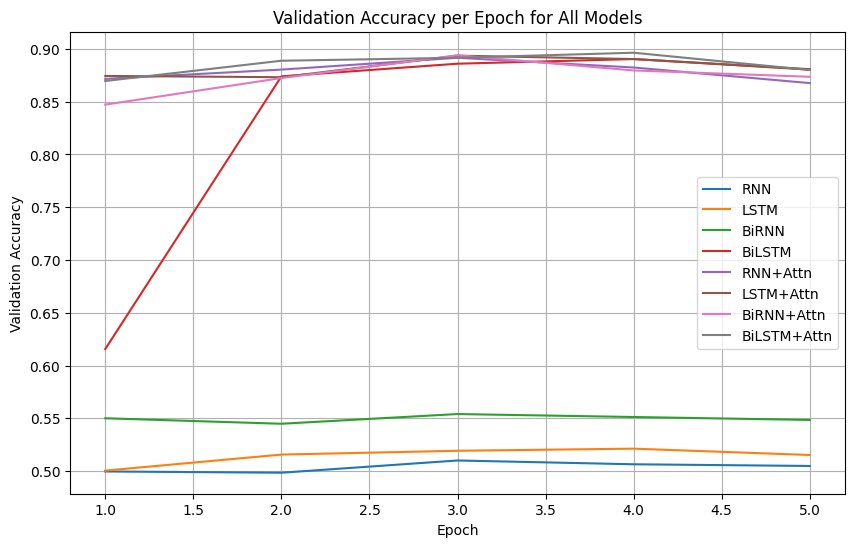

In [16]:
import matplotlib.pyplot as plt

model_variants = {
    "RNN": SentimentRNN(embedding_matrix, rnn_type='RNN', hidden_size=hidden_size, num_layers=num_layers, bidirectional=False, attention=None, num_classes=num_classes),
    "LSTM": SentimentRNN(embedding_matrix, rnn_type='LSTM', hidden_size=hidden_size, num_layers=num_layers, bidirectional=False, attention=None, num_classes=num_classes),
    "BiRNN": SentimentRNN(embedding_matrix, rnn_type='RNN', hidden_size=hidden_size, num_layers=num_layers, bidirectional=True, attention=None, num_classes=num_classes),
    "BiLSTM": SentimentRNN(embedding_matrix, rnn_type='LSTM', hidden_size=hidden_size, num_layers=num_layers, bidirectional=True, attention=None, num_classes=num_classes),
    "RNN+Attn": SentimentRNN(embedding_matrix, rnn_type='RNN', hidden_size=hidden_size, num_layers=num_layers, bidirectional=False, attention=BahdanauAttention(hidden_size), num_classes=num_classes),
    "LSTM+Attn": SentimentRNN(embedding_matrix, rnn_type='LSTM', hidden_size=hidden_size, num_layers=num_layers, bidirectional=False, attention=BahdanauAttention(hidden_size), num_classes=num_classes),
    "BiRNN+Attn": SentimentRNN(embedding_matrix, rnn_type='RNN', hidden_size=hidden_size, num_layers=num_layers, bidirectional=True, attention=BahdanauAttention(hidden_size*2), num_classes=num_classes),
    "BiLSTM+Attn": SentimentRNN(embedding_matrix, rnn_type='LSTM', hidden_size=hidden_size, num_layers=num_layers, bidirectional=True, attention=BahdanauAttention(hidden_size*2), num_classes=num_classes),
}

def train_model_return_val_acc(model, train_loader, val_loader, criterion, optimizer, epochs=5):
    val_accs = []
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs, _ = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs, _ = model(X_batch)
                preds = torch.argmax(outputs, dim=1)
                correct += (preds == y_batch).sum().item()
                total += y_batch.size(0)
        val_acc = correct / total
        val_accs.append(val_acc)
        print(f"Epoch {epoch+1}/{epochs} - Validation Accuracy: {val_acc:.4f}")
    return val_accs

all_val_accs = {}
for name, model in model_variants.items():
    print(f"\nModel: {name}")
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    val_accs = train_model_return_val_acc(model, train_loader, val_loader, criterion, optimizer, epochs=epochs)
    all_val_accs[name] = val_accs

plt.figure(figsize=(10,6))
for name, accs in all_val_accs.items():
    plt.plot(range(1, epochs+1), accs, label=name)
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy per Epoch for All Models")
plt.legend()
plt.grid(True)
plt.show()


Training BiLSTM + Bahdanau Attention
Epoch 1/5 - Validation Accuracy: 0.8652
Epoch 2/5 - Validation Accuracy: 0.8888
Epoch 3/5 - Validation Accuracy: 0.8936
Epoch 4/5 - Validation Accuracy: 0.8900
Epoch 5/5 - Validation Accuracy: 0.8776

Training BiLSTM + LuongDot Attention
Epoch 1/5 - Validation Accuracy: 0.8620
Epoch 2/5 - Validation Accuracy: 0.8936
Epoch 3/5 - Validation Accuracy: 0.8880
Epoch 4/5 - Validation Accuracy: 0.8876
Epoch 5/5 - Validation Accuracy: 0.8824

Training BiLSTM + LuongGeneral Attention
Epoch 1/5 - Validation Accuracy: 0.8528
Epoch 2/5 - Validation Accuracy: 0.8844
Epoch 3/5 - Validation Accuracy: 0.8928
Epoch 4/5 - Validation Accuracy: 0.8808
Epoch 5/5 - Validation Accuracy: 0.8824

Training BiLSTM + LuongConcat Attention
Epoch 1/5 - Validation Accuracy: 0.8708
Epoch 2/5 - Validation Accuracy: 0.8836
Epoch 3/5 - Validation Accuracy: 0.8988
Epoch 4/5 - Validation Accuracy: 0.8968
Epoch 5/5 - Validation Accuracy: 0.8904


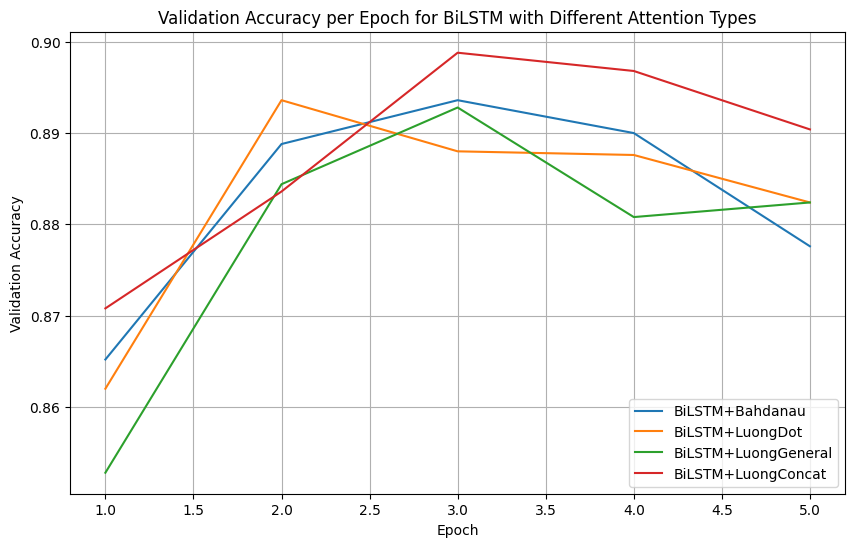

In [17]:
attention_types = {
    "Bahdanau": BahdanauAttention(hidden_size*2),
    "LuongDot": LuongDotAttention(),
    "LuongGeneral": LuongGeneralAttention(hidden_size*2),
    "LuongConcat": LuongConcatAttention(hidden_size*2),
}

bilstm_attn_val_accs = {}

for attn_name, attn_module in attention_types.items():
    print(f"\nTraining BiLSTM + {attn_name} Attention")
    model = SentimentRNN(
        embedding_matrix,
        rnn_type='LSTM',
        hidden_size=hidden_size,
        num_layers=num_layers,
        bidirectional=True,
        attention=attn_module,
        num_classes=num_classes
    ).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    val_accs = train_model_return_val_acc(model, train_loader, val_loader, criterion, optimizer, epochs=epochs)
    bilstm_attn_val_accs[attn_name] = val_accs


# Plotting
plt.figure(figsize=(10,6))
for attn_name, accs in bilstm_attn_val_accs.items():
    plt.plot(range(1, epochs+1), accs, label=f"BiLSTM+{attn_name}")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy per Epoch for BiLSTM with Different Attention Types")
plt.legend()
plt.grid(True)
plt.show()

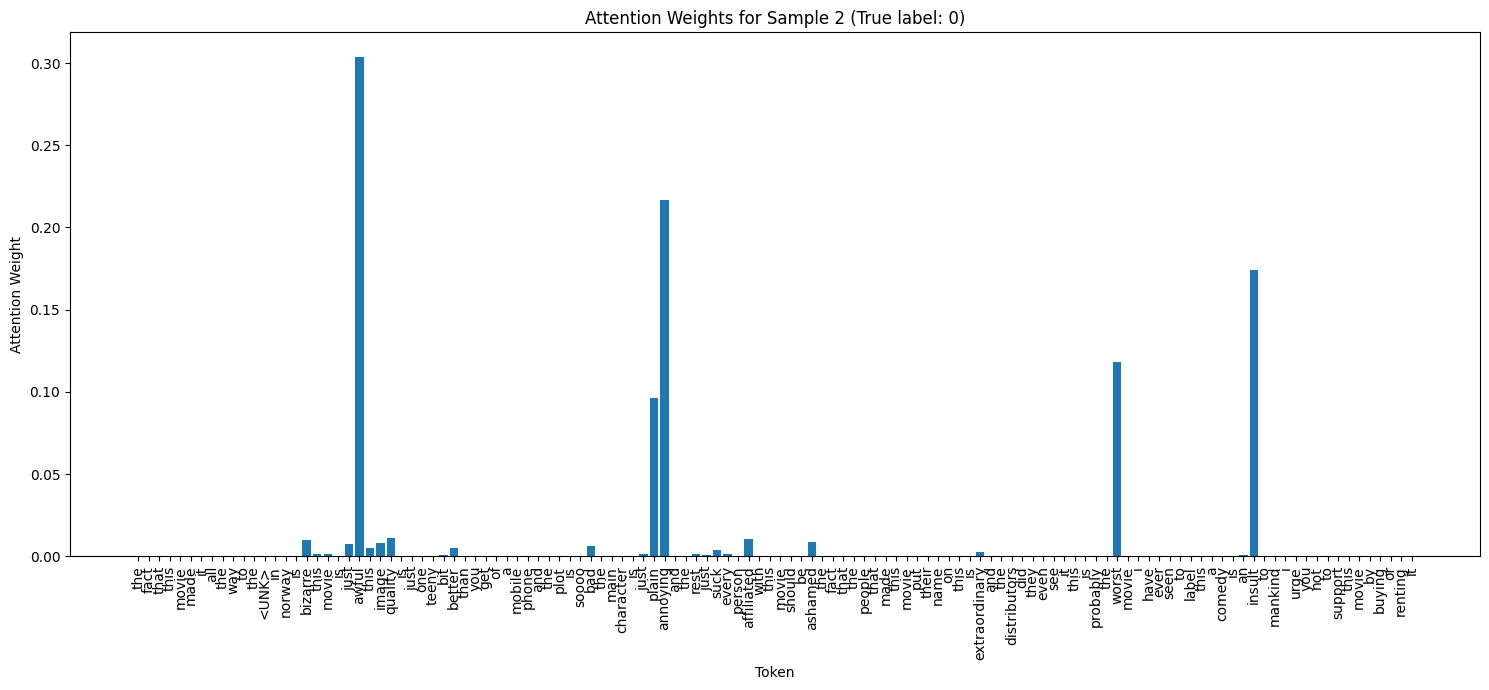

In [28]:
sample_idx = 2
sample_input = X_val[sample_idx].unsqueeze(0).to(device)
sample_label = y_val[sample_idx].item()
sample_tokens = [vocab[idx] for idx in X_val[sample_idx].cpu().numpy() if idx != word2idx['<PAD>']]

model.eval()
with torch.no_grad():
    output, attn_weights = model(sample_input)
    attn_weights = attn_weights.squeeze(0).cpu().numpy()

# Only plot non-padding tokens
attn_weights = attn_weights[:len(sample_tokens)]

plt.figure(figsize=(15, 7))
plt.bar(range(len(attn_weights)), attn_weights)
plt.xticks(range(len(sample_tokens)), sample_tokens, rotation=90)
plt.xlabel("Token")
plt.ylabel("Attention Weight")
plt.title(f"Attention Weights for Sample {sample_idx} (True label: {sample_label})")
plt.tight_layout()
plt.show()

In [24]:
from sklearn.metrics import classification_report, confusion_matrix

model_bilstm_attn = model_bilstm_attn.to(device)
model_bilstm_attn.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch = X_batch.to(device)
        outputs, _ = model_bilstm_attn(X_batch)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(y_batch.numpy())

print("Classification Report (Validation Set):")
print(classification_report(all_labels, all_preds, digits=4))

print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))

Classification Report (Validation Set):
              precision    recall  f1-score   support

           0     0.8943    0.8736    0.8839      1250
           1     0.8765    0.8968    0.8865      1250

    accuracy                         0.8852      2500
   macro avg     0.8854    0.8852    0.8852      2500
weighted avg     0.8854    0.8852    0.8852      2500

Confusion Matrix:
[[1092  158]
 [ 129 1121]]
